In [1]:
%matplotlib inline
%pylab inline

from functools import partial

import menpo.io as mio
from menpo.feature import imgfeature, fast_dsift

from menpo.landmark import labeller, ibug_face_68_trimesh
from menpo.visualize import visualize_images, print_dynamic, plot_graph

from menpofit.result import compute_normalise_point_to_point_error
from menpofit.aam import (
    HolisticAAM, LucasKanadeAAMFitter, 
    holistic_sampling_from_scale,  holistic_sampling_from_step)
from menpofit.aam.algorithm.lk_alabort_arxiv2015 import (
    ProjectOutForwardGaussNewton, 
    ProjectOutInverseGaussNewton,
    ProjectOutAsymmetricGaussNewton,
    ProjectOutBidirectionalGaussNewtonCombined,
    ProjectOutBidirectionalGaussNewtonSimultaneous,
    ProjectOutBidirectionalGaussNewtonAlternated)
from menpofit.visualize import visualize_fitting_result, plot_ced

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
@imgfeature
def fast_dsift2(image):
    if image.n_channels == 3:
        image = image.as_greyscale(mode='average')
    return fast_dsift(image)

## Load AAM

In [3]:
aam = mio.import_pickle('/Users/joan/PhD/Results/alabort_aam_2015/aam.pkl.gz')

## Load test data

In [4]:
test_images = []
for i in mio.import_images('/Users/joan/PhD/DataBases/faces/lfpw/testset/', 
                           verbose=True, max_images=None):    
    i = i.rescale_landmarks_to_diagonal_range(200)
    i = i.crop_to_landmarks_proportion(0.5)
    labeller(i, 'PTS', ibug_face_68_trimesh)
    if i.n_channels == 3:
        test_images.append(i)

Importing assets: [==========] 100% (224/224) - done.                           


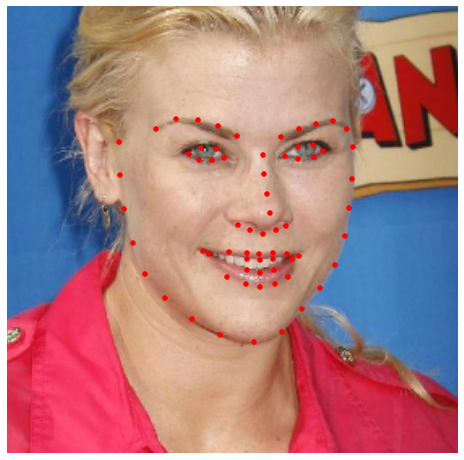

In [5]:
visualize_images(test_images)

## Fit AAM

In [6]:
n_shape = [3, 12]
n_appearance = [0.9, 0.9]
max_iters = [12, 8]
scale = 0.25

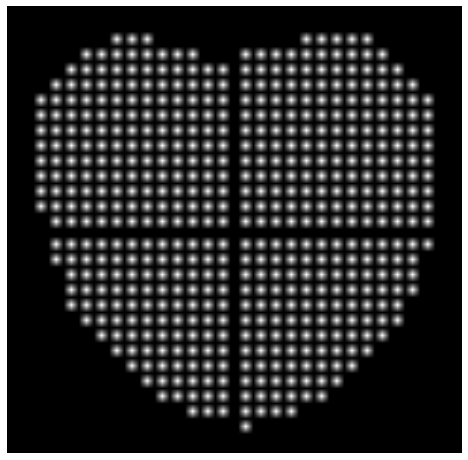

In [7]:
sampling_step_1, sampling_mask_1 = holistic_sampling_from_scale(aam.appearance_models[0].mean(), 
                                                                scale=np.minimum(2 * scale, 1))

sampling_mask_1.view()

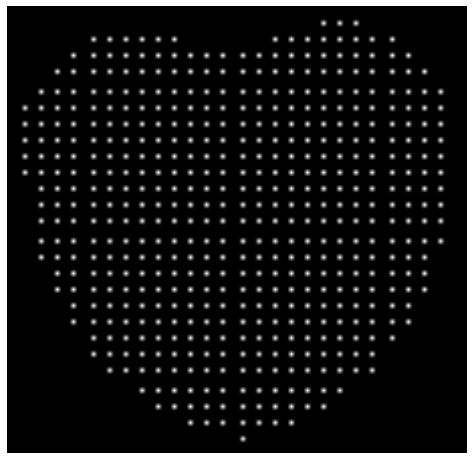

In [8]:
sampling_step_2, sampling_mask_2 = holistic_sampling_from_scale(aam.appearance_models[1].mean(), scale=scale)

sampling_mask_2.view()

In [9]:
sampling_step = [sampling_step_1, sampling_step_2]

#### Sampled AAM Fitter

In [11]:
lambdas = np.arange(0, 1.1, 0.1)

fitters = []
for l in lambdas:

    fitter = LucasKanadeAAMFitter(
        aam, 
        lk_algorithm_cls=partial(ProjectOutBidirectionalGaussNewtonSimultaneous, l=l), 
        n_shape=n_shape, 
        n_appearance=n_appearance,
        sampling=sampling_step)
    
    fitters.append(fitter)

In [12]:
am = fitter.aam.appearance_models[0]
am.variance_ratio()

0.90016625409459916

In [13]:
n_fitters = len(fitters)
legend_entries = ['ini'] + [str(l) for l in lambdas]

#### Fitting loop, noise = 0

In [14]:
# fitters_results_0 = []
# for j, image in enumerate(test_images):
    
#     np.random.seed(j)
    
#     gt_shape = image.landmarks['ibug_face_68_trimesh'].lms
#     initial_shape = fitter.noisy_shape_from_shape(gt_shape, noise_percentage=0.0)

#     for alpha in alphas:
        
#         fr = fitter.fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters, alpha=alpha) 
#         fr.downscale = 0.5
#         fitters_results_0.append(fr)
    
#         print_dynamic(
#             'Image: {} - Initial error: {} - Final error: {}'
#             .format(j, fr.initial_error(), fr.final_error()))

#### Fitting loop, noise = 0.02

In [15]:
# fitters_results_0 = []
# for j, image in enumerate(test_images):
    
#     np.random.seed(j)
    
#     gt_shape = image.landmarks['ibug_face_68_trimesh'].lms
#     initial_shape = fitter.noisy_shape_from_shape(gt_shape, noise_percentage=0.02)

#     for alpha in alphas:
        
#         fr = fitter.fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters, alpha=alpha) 
#         fr.downscale = 0.5
#         fitters_results_0.append(fr)
    
#         print_dynamic(
#             'Image: {} - Initial error: {} - Final error: {}'
#             .format(j, fr.initial_error(), fr.final_error()))

#### Fitting loop, noise = 0.04

In [16]:
fitters_results_0 = []
for j, image in enumerate(test_images):
    
    np.random.seed(j)
    
    gt_shape = image.landmarks['ibug_face_68_trimesh'].lms
    initial_shape = fitters[0].noisy_shape_from_shape(gt_shape, noise_percentage=0.04)

    for fitter in fitters:
        
        fr = fitter.fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
        fr.downscale = 0.5
        fitters_results_0.append(fr)
    
        print_dynamic(
            'Image: {} - Initial error: {} - Final error: {}'
            .format(j, fr.initial_error(), fr.final_error()))

#### Fitting loop, noise = 0.06

In [17]:
# fitters_results_0 = []
# for j, image in enumerate(test_images):
    
#     np.random.seed(j)
    
#     gt_shape = image.landmarks['ibug_face_68_trimesh'].lms
#     initial_shape = fitter.noisy_shape_from_shape(gt_shape, noise_percentage=0.08)

#     for alpha in alphas:
        
#         fr = fitter.fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters, alpha=alpha) 
#         fr.downscale = 0.5
#         fitters_results_0.append(fr)
    
#         print_dynamic(
#             'Image: {} - Initial error: {} - Final error: {}'
#             .format(j, fr.initial_error(), fr.final_error()))

## Visualize Results

Produce combind mean error vs standard deviation graph:

In [18]:
# fitters_results = [fitters_results_0,
#                    fitters_results_1,
#                    fitters_results_2,
#                    fitters_results_3]

In [19]:
# mean_errors = []
# std_errors = []
# median_errors = []

# for frs in fitters_results:

#     errors = []
#     for j in range(n_fitters):
#         errors_j = []
#         for fr in frs[j::n_fitters]:
#             error = compute_normalise_point_to_point_error(fr.final_shape.points[17:, :], 
#                                                            fr.gt_shape.points[17:, :],
#                                                            norm_shape=fr.gt_shape.points)
#             errors_j.append(error)
#         errors.append(errors_j)

#     mean_errs = []
#     std_errs = []
#     median_errs = []
#     for j in range(n_fitters):
#         errs = np.asarray(errors[j])
#         mean_errs.append(np.mean(errs))
#         std_errs.append(np.std(errs))
#         median_errs.append(np.median(errs))
    
#     mean_errors.append(mean_errs)
#     std_errors.append(std_errs)
#     median_errors.append(median_errs)
    
# mean_errors_matrix = np.asarray(mean_errors).T
# std_errors_matrix = np.asarray(std_errors).T
# median_errors_matrix = np.asarray(median_errors).T

In [20]:
# fig = plt.figure()
# plt.clf()
# ax = fig.add_subplot(111)
# ax.set_aspect(1)
# res = ax.imshow(np.array(mean_errors_matrix), cmap=plt.cm.jet, 
#                 alpha=0.5, interpolation='nearest')

# height, width = mean_errors_matrix.shape



# for x in xrange(width):
#     for y in xrange(height):
#         ax.annotate("{0:.4f} ({0:.4f})".format(mean_errors_matrix[x][y], std_errors_matrix[x][y]), xy=(y, x), 
#                     horizontalalignment='center',
#                     verticalalignment='center')

# cb = fig.colorbar(res)
# x_axis_labels = ['0%', '1%', '4%', '6%']
# y_axis_labels = [str(alpha) for alpha in alphas]
# plt.xticks(range(width), x_axis_labels[:width])
# plt.yticks(range(height), y_axis_labels[:height])
# plt.xlabel('Uniform noise')
# plt.ylabel('Sampling rate')

# fig.set_size_inches(2 * fig.get_size_inches())

# plt.savefig('/Users/joan/PhD/Results/alabort_aam_2015/noise_vs_sampling_asymmetric.png', 
#             format='png', dpi=300)

Measure the speed of each fitter:

In [21]:
# %timeit -n 10 fr = fitters[0].fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
# %timeit -n 10 fr = fitters[1].fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
# %timeit -n 10 fr = fitters[2].fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
# %timeit -n 10 fr = fitters[3].fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 

For a particular level of noise: 

1) visualize fitting results:

In [22]:
fitters_results = fitters_results_0

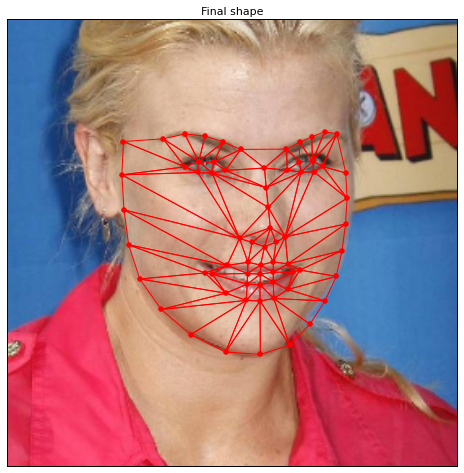

In [23]:
visualize_fitting_result(fitters_results)

2) Produce CED graph:

In [24]:
errors = [[]]
for fr in fitters_results[::n_fitters]:
    error = compute_normalise_point_to_point_error(fr.initial_shape.points[17:, :], 
                                                   fr.gt_shape.points[17:, :],
                                                   norm_shape=fr.gt_shape.points)
    errors[0].append(error)

for j in range(n_fitters):
    errors_j = []
    for fr in fitters_results[j::n_fitters]:
        error = compute_normalise_point_to_point_error(fr.final_shape.points[17:, :], 
                                                       fr.gt_shape.points[17:, :],
                                                       norm_shape=fr.gt_shape.points)
        errors_j.append(error)
    errors.append(errors_j)

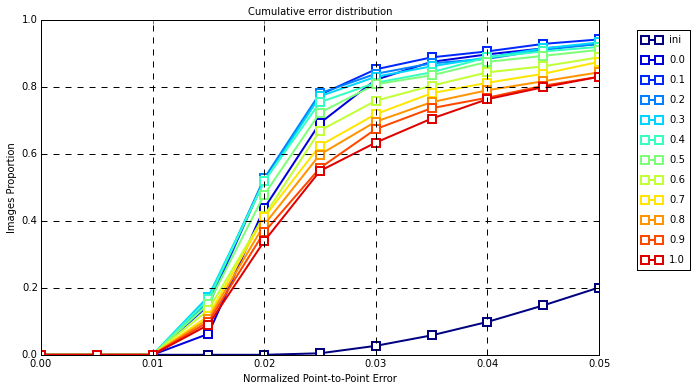

In [25]:
plot_ced(errors, legend_entries=legend_entries)

3) Produce fitting statistics:

In [26]:
for j, e in enumerate(errors):
    print legend_entries[j], '\tmean:{0:.4f}'.format(np.mean(e)), '\tstd:{0:.4f}'.format(np.std(e)), '\tmedian:{0:.4f}'.format(np.median(e))

ini 	mean:0.0735 	std:0.0264 	median:0.0718
0.0 	mean:0.0256 	std:0.0162 	median:0.0209
0.1 	mean:0.0239 	std:0.0151 	median:0.0197
0.2 	mean:0.0247 	std:0.0178 	median:0.0198
0.3 	mean:0.0258 	std:0.0214 	median:0.0197
0.4 	mean:0.0266 	std:0.0229 	median:0.0196
0.5 	mean:0.0279 	std:0.0252 	median:0.0202
0.6 	mean:0.0303 	std:0.0275 	median:0.0213
0.7 	mean:0.0327 	std:0.0304 	median:0.0221
0.8 	mean:0.0348 	std:0.0334 	median:0.0230
0.9 	mean:0.0383 	std:0.0396 	median:0.0235
1.0 	mean:0.0385 	std:0.0376 	median:0.0242


4) Produce mean and median error convergence graphs:

In [ ]:
mean_errors = []
std_errors = []
median_errors = []
for j in range(n_fitters):
    errors = []
    for fr in fitters_results[j::n_fitters]:
        errs = []
        for shape in fr.shapes:
            err = compute_normalise_point_to_point_error(shape.points[17:, :], 
                                                         fr.gt_shape.points[17:, :],
                                                          norm_shape=fr.gt_shape.points)
            errs.append(err)
        while len(errs) < 22:
            errs += errs[-1]
        errors.append(errs)
    mean_errors.append(np.mean(errors, axis=0))
    std_errors.append(np.std(errors, axis=0))
    median_errors.append(np.median(errors, axis=0))

[ 0.07348121  0.05059966  0.0390408   0.03318805  0.03063229  0.02957621
  0.02891202  0.02860298  0.02843554  0.02826338  0.02805624  0.02793235
  0.02790602  0.02790602  0.02513072  0.02454826  0.02498889  0.02490949
  0.02535355  0.02528785  0.02568674  0.02556905]
[ 0.07348121  0.05414859  0.04231957  0.03585928  0.03218639  0.03037453
  0.02935668  0.02878147  0.02849586  0.02823971  0.02797288  0.02773037
  0.02753462  0.02753462  0.02404249  0.02347273  0.02351684  0.02358056
  0.02366569  0.02376181  0.02380743  0.02392327]
[ 0.07348121  0.05597779  0.04453796  0.0380088   0.03412273  0.03188712
  0.03061971  0.02975912  0.0292156   0.02892584  0.02877183  0.02862859
  0.02847403  0.02847403  0.02483087  0.02441354  0.02442328  0.02453994
  0.02461469  0.02469038  0.02473093  0.02474821]

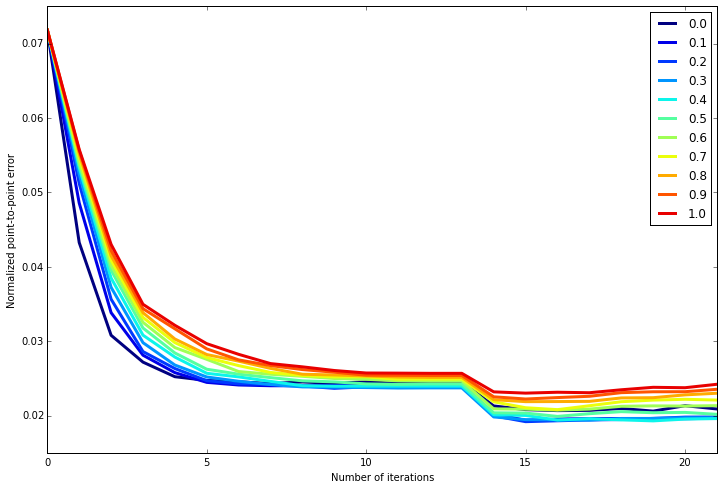

In [31]:
import  matplotlib.pyplot as plt
from menpo.visualize.viewmatplotlib import sample_colours_from_colourmap

colours = sample_colours_from_colourmap(n_fitters, 'jet')

fig = plt.figure()
plt.hold(True)


for i in range(len(mean_errors)):
    plt.plot(np.arange(0, len(mean_errors[i])),
             median_errors[i],
             color=colours[i],
             linewidth=3)
    
plt.xlabel('Number of iterations')
plt.ylabel('Normalized point-to-point error')
plt.xlim((0, len(mean_errors[i]) - 1))
plt.ylim((0.015, 0.075))
plt.legend(legend_entries[1:])

fig.set_size_inches(2 * fig.get_size_inches())

plt.savefig('/Users/joan/PhD/Results/alabort_aam_2015/mean_error_vs_iters_asymmetric_0.04.png', 
            format='png', dpi=300)

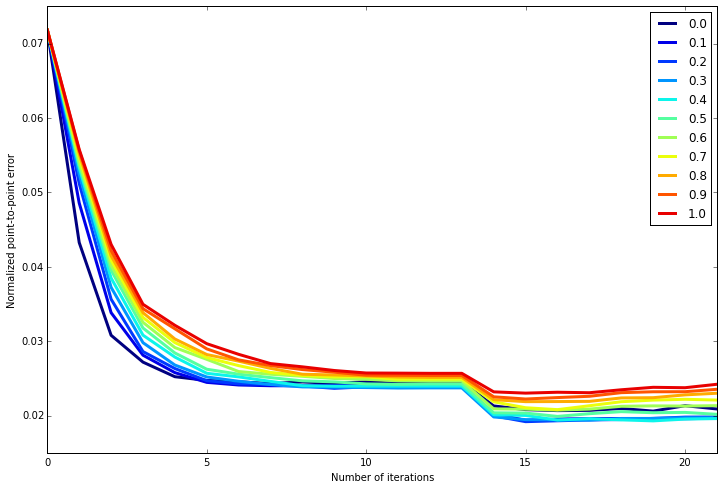

In [29]:
import  matplotlib.pyplot as plt
from menpo.visualize.viewmatplotlib import sample_colours_from_colourmap

colours = sample_colours_from_colourmap(n_fitters, 'jet')

fig = plt.figure()
plt.hold(True)

for i in range(len(mean_errors)):
    plt.plot(np.arange(0, len(mean_errors[i])),
             median_errors[i],
             color=colours[i],
             linewidth=3)
    
plt.xlabel('Number of iterations')
plt.ylabel('Normalized point-to-point error')
plt.xlim((0, len(mean_errors[i]) - 1))
plt.ylim((0.015, 0.075))
plt.legend(legend_entries[1:])

fig.set_size_inches(2 * fig.get_size_inches())

plt.savefig('/Users/joan/PhD/Results/alabort_aam_2015/median_error_vs_iters_asymmetric_0.04.png', 
            format='png', dpi=300)

## Other

In [28]:
# import  matplotlib.pyplot as plt
# from menpo.visualize.viewmatplotlib import sample_colours_from_colourmap

# colours = sample_colours_from_colourmap(n_fitters, 'jet')

# fig = plt.figure()
# plt.hold(True)

# for i in range(len(mean_errors)):
#     plt.errorbar(np.arange(0, len(mean_errors[i])), 
#                  mean_errors[i], 
#                  yerr=0.1 * std_errors[i],
#                  color=colours[i],
#                  marker='o',
#                  markersize=10,
#                  linewidth=1.5)
#     plt.fill_between(np.arange(0, len(mean_errors[i])), 
#                      mean_errors[i] - 0.1 * std_errors[i], 
#                      mean_errors[i] + 0.1 * std_errors[i],
#                      color=colours[i],
#                      alpha=0.1)
#     plt.plot(np.arange(0, len(mean_errors[i])),
#              median_errors[i],
#              '--',
#              color=colours[i],
#              marker='^',
#              markersize=10,
#              linewidth=1,
#              alpha=0.75)
    
# plt.xlabel('Normalized point-to-point error')
# plt.ylabel('Number of iterations')
# plt.xlim((0, len(mean_errors[i]) - 1))
# plt.legend(['12.5%', '12.5%', 
#             '25%', '25%', 
#             '50%', '50%', 
#             '100%', '100%',  ])

# fig.set_size_inches(1.5*fig.get_size_inches())

In [29]:
# import line_profiler
# import IPython

# ip = IPython.get_ipython()
# ip.define_magic('lprun', line_profiler.magic_lprun)

In [30]:
# %lprun -f ProjectOutAsymmetricGaussNewton._solve fitter_3.fit_from_shape(i, s, gt_shape=gt_s, max_iters=2) 